In [1]:
%%javascript
IPython.notebook.kernel.execute('version = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# coding=gbk
import os
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")
import pickle, datetime, copy
from copy import deepcopy
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, evaluator, utils_train
import evaluator as ev
from evaluator import Evaluator



# 文件处理参数
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
## 原始数据文件是否已经更新
if_update = False
## 预处理逻辑/参数变更 or 缓存的pickle需要更新时，设为False (注意利用的数据格式，避免用本月行情预测本月行情。)
use_cache = True
version = version.split('.')[0]

# 预处理参数
if_cls = True
align_to = 'month'
use_lag_x = 15
begT = '2004-01'
endT = datetime.date.today()

# 滚动训练次数
n_splits = 10
print('version:', version)

/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


version: featcheck_RF_0926


/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [3]:
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, use_lag_x, align_to, begT, endT)
if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

data pickle loaded


In [4]:
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = {}
# 原始的Xy切片之前要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]), "\nStart training.......................")
        # 因为每个时间段筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False force_train
        models = utils_train.get_models_dump(X_train, y_train, pipe='cls', version=version, force_train=False, same_model=True)
        models_list[str(X_train.index[-1])]=deepcopy(models)

/nTRAIN period: 2006-12 -> 2014-01 
Start training.......................
...initializing MacroFE
model 0 pickle loaded


/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2015-06 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2016-11 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2018-04 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 

In [5]:
evalor_list = []
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)

        evalor = Evaluator(models_list[str(X_train.index[-1])], if_cls, X_test_long, y_test, y_test_ret, X_train, y_train)
        evalor_list.append(deepcopy(evalor))
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:", str(evalor.excess_ann_ret))
        del evalor
        


TEST period: 2014-02 -> 2015-06 
Start testing...........................

predicting test set for asset 0
...transforming MacroFE
第0个资产的样本外 accuracy score: 0.4117647058823529

predicting test set for asset 1
...transforming MacroFE
第1个资产的样本外 accuracy score: 0.23529411764705882

predicting test set for asset 2
...transforming MacroFE
第2个资产的样本外 accuracy score: 0.4117647058823529

predicting test set for asset 3
...transforming MacroFE
第3个资产的样本外 accuracy score: 0.11764705882352941

predicting test set for asset 4
...transforming MacroFE
第4个资产的样本外 accuracy score: 0.17647058823529413

predicting test set for asset 5
...transforming MacroFE
第5个资产的样本外 accuracy score: 0.11764705882352941

predicting test set for asset 6
...transforming MacroFE
第6个资产的样本外 accuracy score: 0.23529411764705882

predicting test set for asset 7
...transforming MacroFE
第7个资产的样本外 accuracy score: 0.6470588235294118

predicting test set for asset 8
...transforming MacroFE
第8个资产的样本外 accuracy score: 0.35294117647058826



In [6]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]
port_poss = [i.port_pos for i in evalor_list]

In [7]:
# 超额收益分析
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2014-02 -> 2015-06 的年化超额收益为:
return    0.237191
dtype: float64
2015-07 -> 2016-11 的年化超额收益为:
return   -0.04279
dtype: float64
2016-12 -> 2018-04 的年化超额收益为:
return    0.008594
dtype: float64
2018-05 -> 2019-09 的年化超额收益为:
return    0.086479
dtype: float64
2019-10 -> 2021-02 的年化超额收益为:
return   -0.291082
dtype: float64
2021-03 -> 2022-07 的年化超额收益为:
return   -0.046242
dtype: float64


In [8]:
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0,0,0,0
第0个资产:,0.411765,0.470588,0.117647,0.470588,0.411765,0.411765
第1个资产:,0.235294,0.352941,0.411765,0.235294,0.352941,0.352941
第2个资产:,0.411765,0.294118,0.352941,0.588235,0.529412,0.411765
第3个资产:,0.117647,0.117647,0.352941,0.176471,0.117647,0.294118
第4个资产:,0.176471,0.058824,0.411765,0.294118,0.411765,0.352941
第5个资产:,0.117647,0.117647,0.411765,0.294118,0.529412,0.529412
第6个资产:,0.235294,0.294118,0.294118,0.176471,0.352941,0.352941
第7个资产:,0.647059,0.352941,0.352941,0.294118,0.352941,0.235294
第8个资产:,0.352941,0.352941,0.235294,0.352941,0.176471,0.470588
第9个资产:,0.235294,0.235294,0.294118,0.529412,0.117647,0.411765


In [9]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.38235294117647056
第1个资产:
0.3235294117647059
第2个资产:
0.4313725490196078
第3个资产:
0.19607843137254902
第4个资产:
0.2843137254901961
第5个资产:
0.3333333333333333
第6个资产:
0.2843137254901961
第7个资产:
0.37254901960784315
第8个资产:
0.3235294117647059
第9个资产:
0.30392156862745096


[]

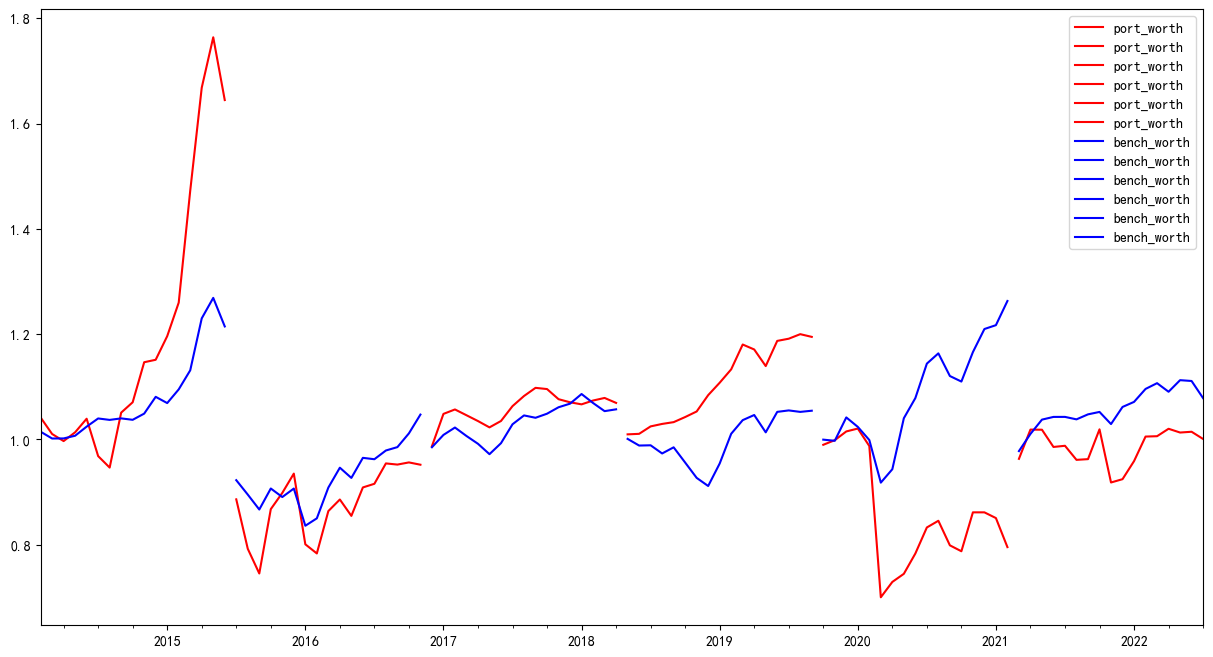

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [11]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

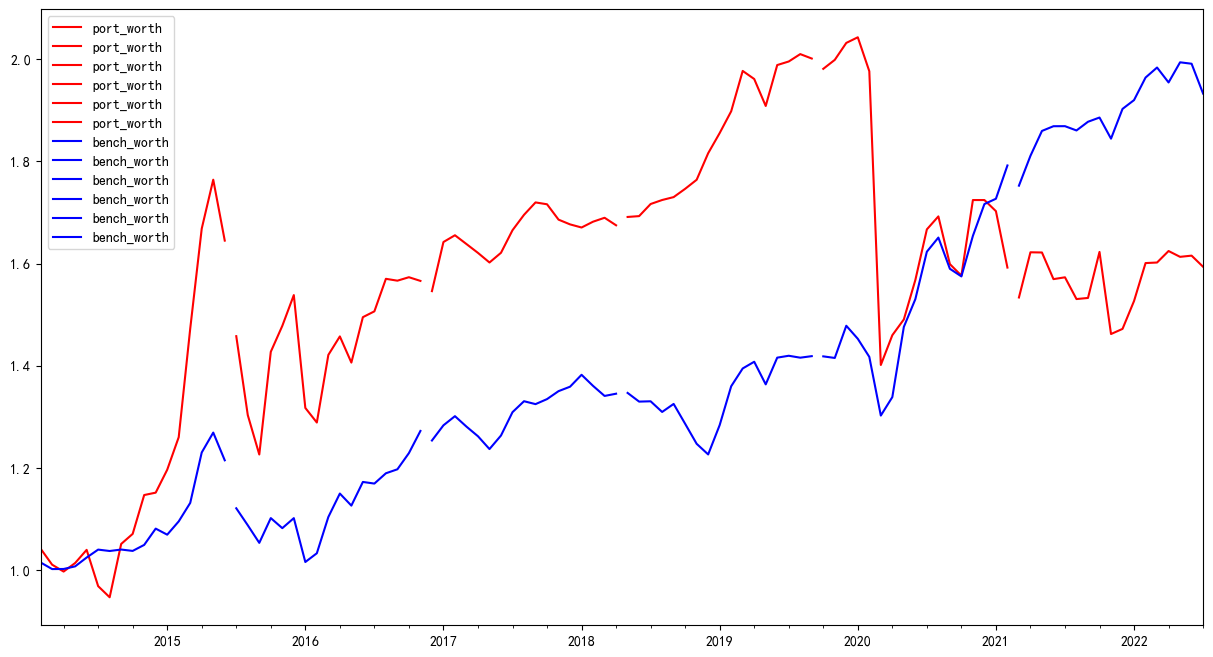

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [13]:
# 宏观因子重要性分析

In [14]:
models_list.keys()

dict_keys(['2014-01', '2015-06', '2016-11', '2018-04', '2019-09', '2021-02'])

In [15]:
values=models_list['2014-01'][9][-1][-1].feature_importances_

In [16]:
# values=models_list['2016-01'][9][-1][-1].coef_
# values

In [17]:
names=models_list['2014-01'][9][:-1].get_feature_names_out()
names

array(['lr1__self__lr0__var65(t-11)M0000705',
       'lr1__self__lr0__var391(t-10)G0003650_resid',
       'lr1__self__lr0__var391(t-3)G0003650_resid',
       'lr1__self__lr0__var391(t-1)G0003650_resid',
       'lr1__self__ridge0__var65(t-11)M0000705',
       'lr1__self__ridge0__var391(t-10)G0003650_resid',
       'lr1__self__ridge0__var391(t-3)G0003650_resid',
       'lr1__self__ridge0__var391(t-1)G0003650_resid',
       'lr1__self__sgd0__var65(t-11)M0000705',
       'lr1__self__sgd0__var391(t-10)G0003650_resid',
       'lr1__self__sgd0__var391(t-3)G0003650_resid',
       'lr1__self__rf0__var275(t-4)G0003351',
       'lr1__self__gbr0__var138(t-1)M0010131_resid',
       'lr1__talibFE__19_mom', 'lr1__talibFE__56_mom',
       'lr1__talibFE__57_mom', 'lr1__talibFE__125_mom',
       'lr1__talibFE__141_PPO', 'lr1__talibFE__154_mom',
       'lr1__talibFE__222_rsi6', 'ridge1__self__lr0__var65(t-11)M0000705',
       'ridge1__self__lr0__var391(t-10)G0003650_resid',
       'ridge1__self__lr0__var

In [18]:
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])

In [19]:
fea_imp.sort_values(by='values', axis=1, ascending=False)

,95,91,88,82,79,99,87,12,63,66,...,25,40,23,51,49,18,17,47,44,0
names,gbr1__talibFE__110_macdhist,gbr1__talibFE__27_macdhist,gbr1__self__gbr0__var138(t-1)M0010131_resid,gbr1__self__gbr0__var562(t-13)M0051559,rf1__talibFE__226_rsi6,gbr1__talibFE__226_rsi6,gbr1__self__gbr0__var407(t-2)G0003681_resid,lr1__self__gbr0__var138(t-1)M0010131_resid,rf1__self__gbr0__var219(t-6)M5568367_resid,rf1__talibFE__52_mom10,...,ridge1__self__ridge0__var391(t-10)G0003650_resid,sgd1__self__lr0__var7(t-12)M0001427_resid,ridge1__self__lr0__var391(t-1)G0003650_resid,sgd1__talibFE__0_yoy,sgd1__self__sgd0__var307(t-9)G1100344,lr1__talibFE__154_mom,lr1__talibFE__141_PPO,sgd1__self__sgd0__var65(t-11)M0000705,sgd1__self__ridge0__var65(t-11)M0000705,lr1__self__lr0__var65(t-11)M0000705
values,0.0716,0.063795,0.06046,0.054036,0.053846,0.051954,0.05162,0.035346,0.03402,0.033644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
values=models_list['2018-03'][9][-1][-1].feature_importances_
names=models_list['2018-03'][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

KeyError: '2018-03'

In [ ]:
values=models_list['2020-05'][9][-1][-1].feature_importances_
names=models_list['2020-05'][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

In [ ]:
# 仓位分析

In [21]:
port_poss = [i.port_pos for i in evalor_list]
port_positions = [utils_eda.trans_columns_name(i) for i in port_poss]

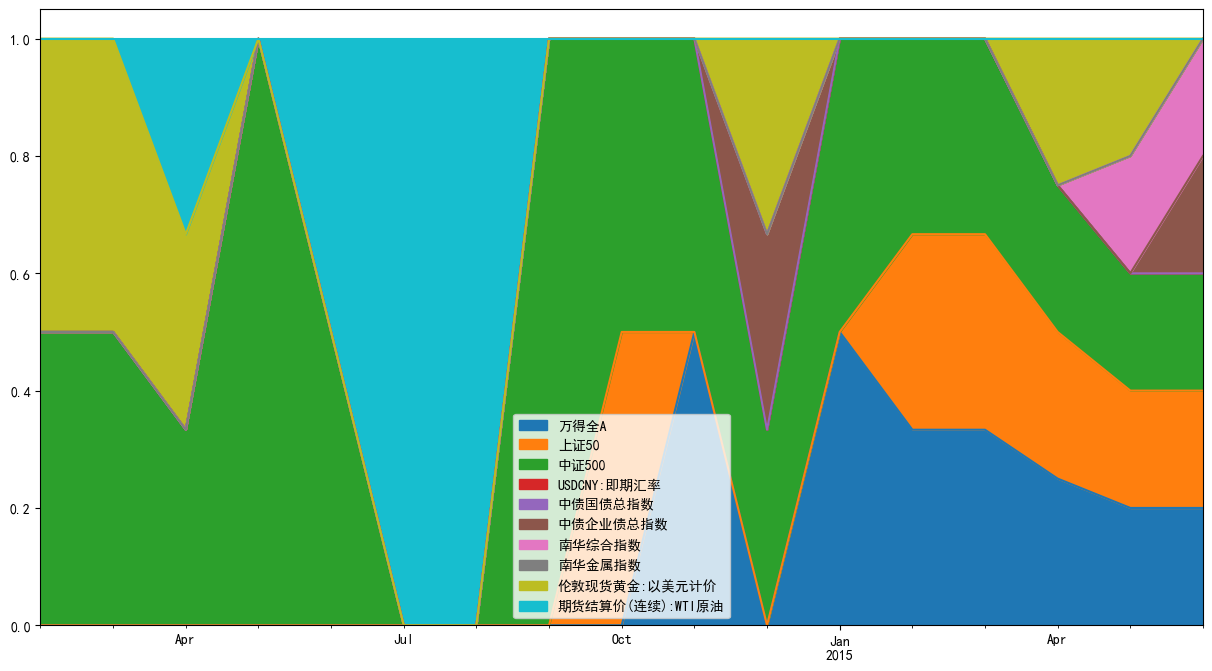

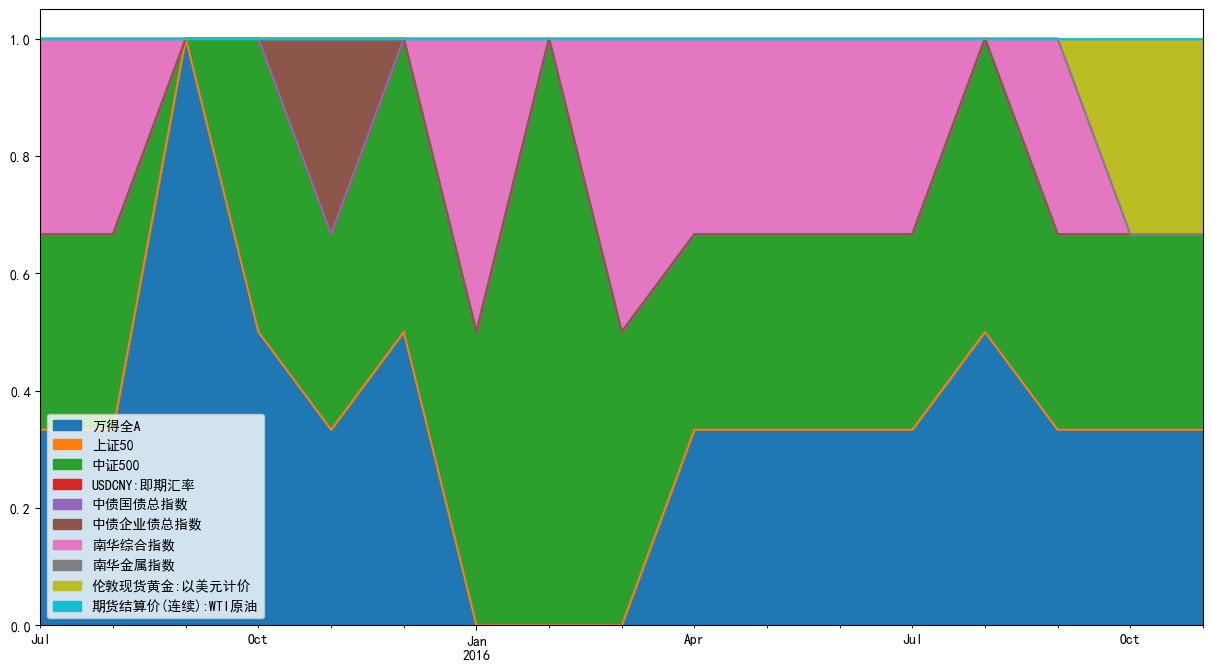

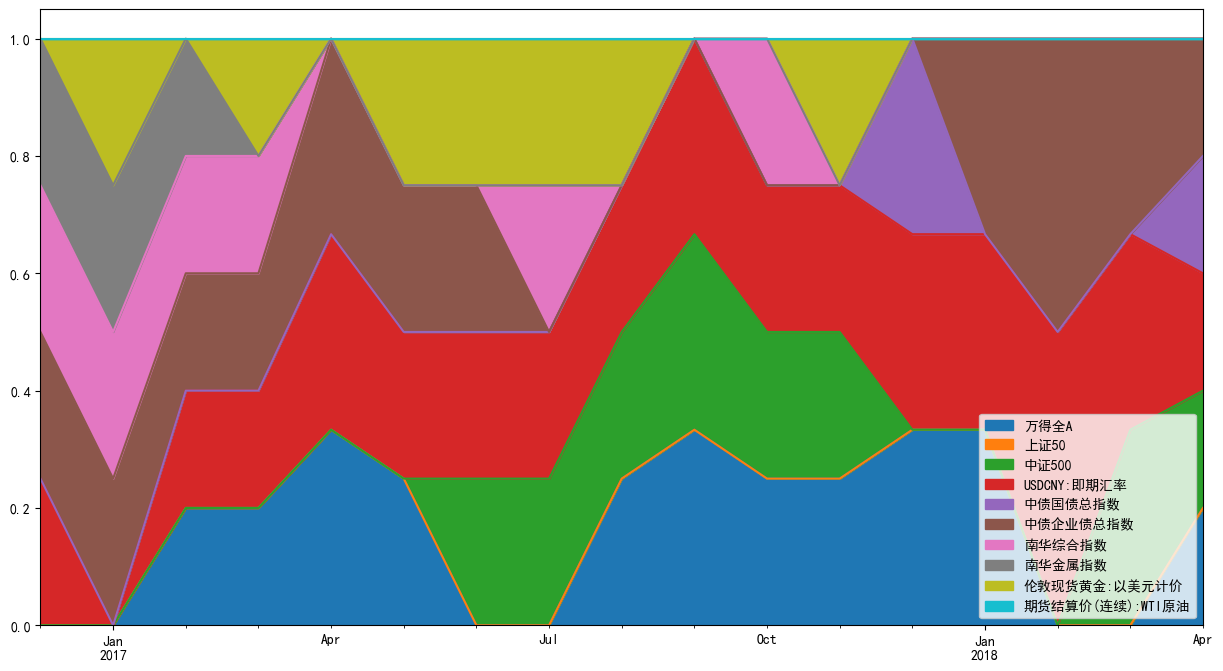

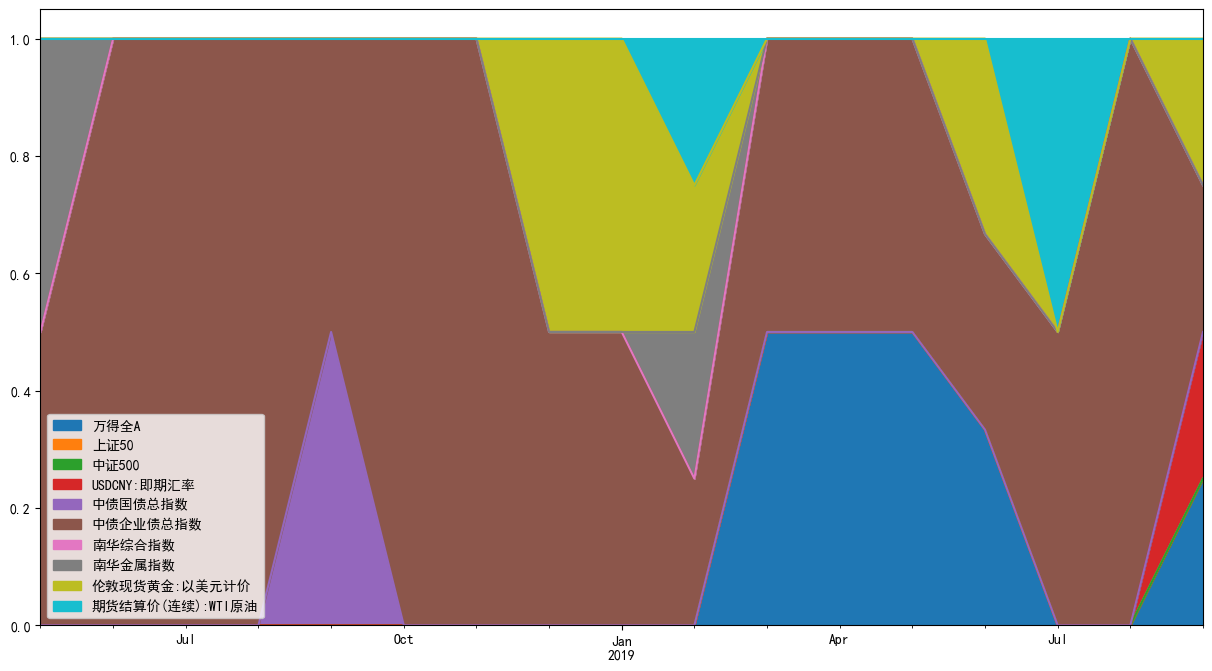

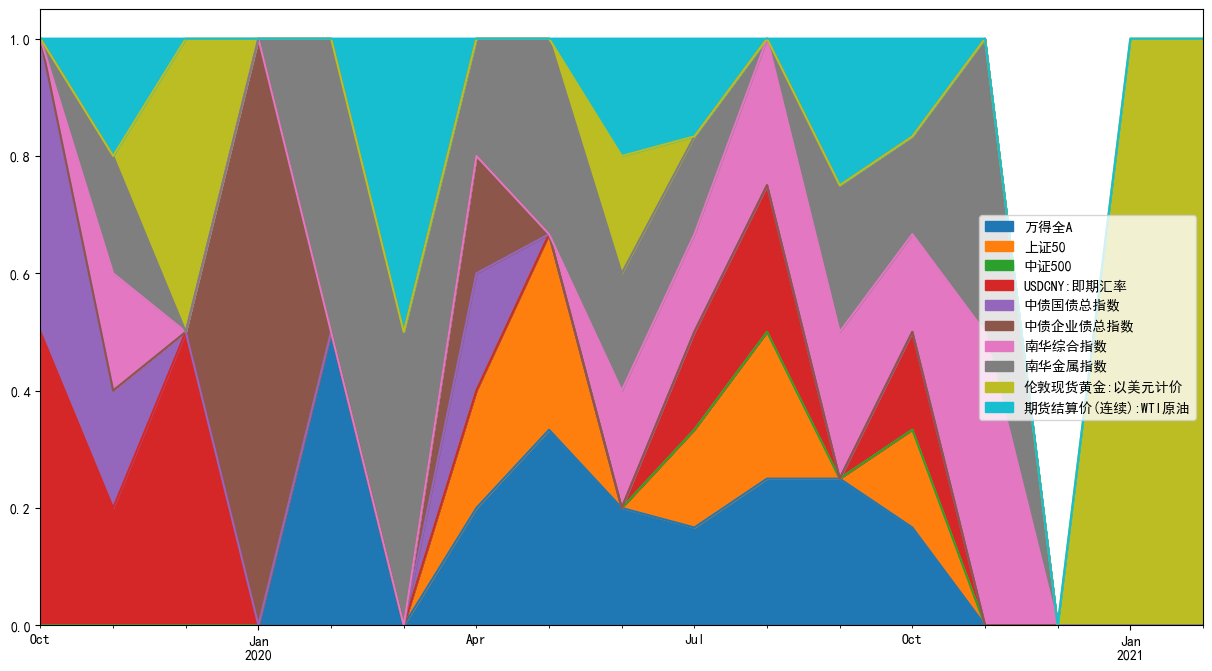

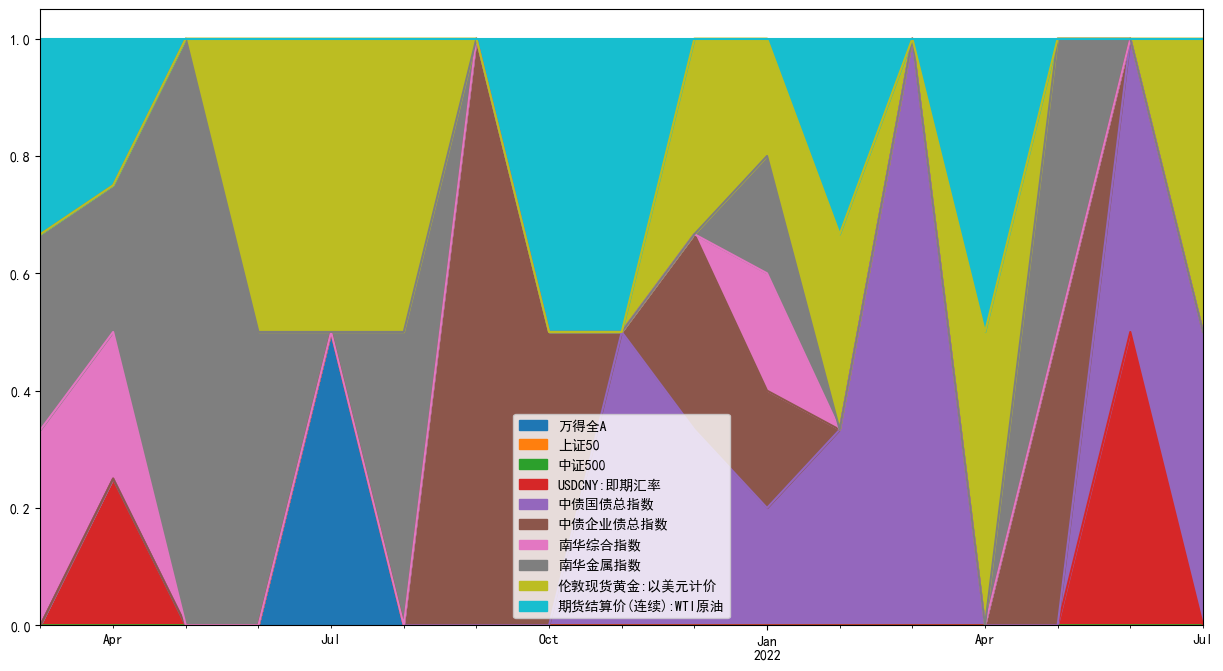

In [22]:
for i in range(len(port_poss)):
    port_positions[i].plot(kind='area',figsize=(15, 8))